### 1. ResNet-20 with Cross Entropy Loss as Usual

In [ ]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np

# Define an abstracted 3x3 convolutional layer
def conv_filter_3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)


# Define a block of convolutional layers with identity shortcuts (Option A)
# Note that each block has 2 convolution layers so for ResNet 20, we will have
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = conv_filter_3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = conv_filter_3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        # save residual
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        # add residual
        out += residual
        out = self.relu(out)
        return out

# Define ResNet_20 class
# 3 no. blocks for layers with {16, 32, 64} activation maps to get 20 layers
# so to instantiate ResNet 20, we set block to be [3, 3, 3]
class ResNet_20(nn.Module):
    def __init__(self, block, cnn_layers, num_class=10):
        super(ResNet_20, self).__init__()
        self.in_channels = 16
        self.conv = conv_filter_3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.layer1 = self.create_layer(block, 16, cnn_layers[0])
        self.layer2 = self.create_layer(block, 32, cnn_layers[1], 2)
        self.layer3 = self.create_layer(block, 64, cnn_layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, 10)
        
        # initialize Xavier (Glorot) normal weights
        nn.init.xavier_normal_(self.conv.weight)
        nn.init.xavier_normal_(self.fc.weight)

    def create_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv_filter_3x3(self.in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels))
        
        cnn_layers = []
        cnn_layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            cnn_layers.append(block(out_channels, out_channels))
        return nn.Sequential(*cnn_layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


i. HYPERPARAMTER TUNING: Now that we have implemented ResNet-20 with "option A", we carry out tuning by data augmentation and decaying the learning rate, taking inspiration from Section 4.2 from the ResNet paper.

In [ ]:
# DATA PRE-PROCESSING
###############################################################################
# useful libraries
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

#############################################
# specify preprocessing function
transform_train_base = transforms.Compose(
    [
        transforms.RandomCrop(size=32, padding=4),
        transforms.RandomRotation(11),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

transform_test_base = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
#############################################

In [ ]:
# LOAD DATA SET AND CONSTRUCT DATA LOADERS
#################################################################################
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

DATA_ROOT = "./data_baseline"
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, mode="train", download=True, transform=transform_train_base
)
test_set = CIFAR10(root=DATA_ROOT, mode="test", download=True, transform=transform_test_base)

# construct dataloader
train_loader = DataLoader(
    train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=4  # your code
)
test_loader = DataLoader(
    test_set, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=4
)
#############################################

Using downloaded and verified file: ./data_baseline/cifar10_trainval_F22.zip
Extracting ./data_baseline/cifar10_trainval_F22.zip to ./data_baseline
Files already downloaded and verified
Using downloaded and verified file: ./data_baseline/cifar10_test_F22.zip
Extracting ./data_baseline/cifar10_test_F22.zip to ./data_baseline
Files already downloaded and verified


In [ ]:
# DEFINE DEVICE, INSTANTIATE MODEL AND MOVE TO GPU
#################################################################################
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Define Model
model_baseline = ResNet_20(ResBlock, [3, 3, 3])
model_baseline.to(device)

Run on GPU...


ResNet_20(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-

In [ ]:
# SET UP LOSS FUNCTION AND OPTIMIZER
#################################################################################
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = torch.optim.SGD(model_baseline.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)


In [ ]:
# some hyperparameters
# total number of training epochs
EPOCHS = 190
DECAY_EPOCHS = [120, 150]
DECAY = 0.1

# start the training/validation process
best_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i in DECAY_EPOCHS and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    #######################
    # switch to train mode
    model_baseline.train()
    
    #######################
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.type(torch.LongTensor)
        targets = targets.to(device)
        
        # compute the output and loss
        outputs = model_baseline(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        
        # count the number of correctly predicted samples in the current batch
        # torch.max here returns maximum confidence score, index (index maps to class)
        _, predicted = torch.max(outputs.data, 1)
        correct_examples += (predicted == targets).float().sum()
        total_examples += len(targets)
        train_loss += loss.item()
        
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training Loss: %.4f, Training acc: %.4f" %(avg_loss, avg_acc))

    # Start Testing Code
    #######################
    model_baseline.eval()
    
    #######################
    total = 0
    correct = 0
    test_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_baseline(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(test_loader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test Acc=%.4f" % (test_loss / (num_val_steps), val_acc))

    if val_acc > best_acc:
        best_acc = val_acc
        print("Saving...")
        torch.save(model_baseline.state_dict(), "model_baseline.pt")
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation Accuracy of Baseline Res Net 20: {best_acc:.4f}")

==> Training starts!
Epoch 0:


KeyboardInterrupt: ignored

Best Test Accuracy of 0.9236

### 2. Cutout

In [ ]:
import pdb
import argparse
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision.utils import make_grid
from torchvision import datasets, transforms

from util.misc import CSVLogger
from util.cutout import Cutout

#from model.resnet import ResNet18
#from model.wide_resnet import WideResNet

model_options = ['resnet20']
dataset_options = ['cifar10']

parser = argparse.ArgumentParser(description='CNN')
parser.add_argument('-f')
parser.add_argument('--dataset', '-d', default='cifar10',
                    choices=dataset_options)
parser.add_argument('--model', '-a', default='resnet20',
                    choices=model_options)
parser.add_argument('--batch_size', type=int, default=128,
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=200,
                    help='number of epochs to train (default: 20)')
parser.add_argument('--learning_rate', type=float, default=0.1,
                    help='learning rate')
parser.add_argument('--data_augmentation', action='store_true', default=False,
                    help='augment data by flipping and cropping')
parser.add_argument('--cutout', action='store_true', default=True,
                    help='apply cutout')
parser.add_argument('--n_holes', type=int, default=1,
                    help='number of holes to cut out from image')
parser.add_argument('--length', type=int, default=16,
                    help='length of the holes')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=0,
                    help='random seed (default: 1)')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

test_id = args.dataset + '_' + args.model

print(args)

# Image Preprocessing
if args.dataset == 'svhn':
    normalize = transforms.Normalize(mean=[x / 255.0 for x in[109.9, 109.7, 113.8]],
                                     std=[x / 255.0 for x in [50.1, 50.6, 50.8]])
else:
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])
if args.data_augmentation:
    train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)
if args.cutout:
    train_transform.transforms.append(Cutout(n_holes=args.n_holes, length=args.length))


test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

if args.dataset == 'cifar10':
    num_classes = 10
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=args.batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)



Namespace(batch_size=128, cuda=True, cutout=True, data_augmentation=False, dataset='cifar10', epochs=200, f='/root/.local/share/jupyter/runtime/kernel-40802c1a-3934-457f-a47a-a9281b27c568.json', learning_rate=0.1, length=16, model='resnet20', n_holes=1, no_cuda=False, seed=0)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
if args.model == 'resnet20':
    cnn = ResNet_20(ResBlock, [3, 3, 3])

cnn = cnn.cuda()
criterion = nn.CrossEntropyLoss().cuda()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=args.learning_rate,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)

scheduler = MultiStepLR(cnn_optimizer, milestones=[60, 120, 160], gamma=0.2)

#filename = 'logs/' + test_id + '.csv'
#csv_logger = CSVLogger(args=args, fieldnames=['epoch', 'train_acc', 'test_acc'], filename=filename)


def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.
    total = 0.
    for images, labels in loader:
        images = images.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            pred = cnn(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = correct / total
    cnn.train()
    return val_acc


for epoch in range(args.epochs):

    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))

        images = images.cuda()
        labels = labels.cuda()

        cnn.zero_grad()
        pred = cnn(images)

        xentropy_loss = criterion(pred, labels)
        xentropy_loss.backward()
        cnn_optimizer.step()

        xentropy_loss_avg += xentropy_loss.item()

        # Calculate running average of accuracy
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels.data).sum().item()
        accuracy = correct / total

        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)

    test_acc = test(test_loader)
    tqdm.write('test_acc: %.3f' % (test_acc))

    scheduler.step()     # Use this line for PyTorch >=1.4

    #row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    #csv_logger.writerow(row)

torch.save(cnn.state_dict(), 'model_cutout_2.pt')
#csv_logger.close()

Epoch 0: 100%|██████████| 391/391 [00:14<00:00, 27.69it/s, acc=0.375, xentropy=1.682]


test_acc: 0.475


Epoch 1: 100%|██████████| 391/391 [00:14<00:00, 27.61it/s, acc=0.558, xentropy=1.218]


test_acc: 0.603


Epoch 2: 100%|██████████| 391/391 [00:14<00:00, 27.73it/s, acc=0.637, xentropy=1.021]


test_acc: 0.672


Epoch 3: 100%|██████████| 391/391 [00:14<00:00, 27.81it/s, acc=0.686, xentropy=0.891]


test_acc: 0.675


Epoch 4: 100%|██████████| 391/391 [00:14<00:00, 27.63it/s, acc=0.710, xentropy=0.825]


test_acc: 0.718


Epoch 5: 100%|██████████| 391/391 [00:14<00:00, 27.73it/s, acc=0.731, xentropy=0.766]


test_acc: 0.741


Epoch 6: 100%|██████████| 391/391 [00:14<00:00, 27.69it/s, acc=0.747, xentropy=0.729]


test_acc: 0.703


Epoch 7: 100%|██████████| 391/391 [00:14<00:00, 27.70it/s, acc=0.756, xentropy=0.703]


test_acc: 0.757


Epoch 8: 100%|██████████| 391/391 [00:14<00:00, 27.39it/s, acc=0.764, xentropy=0.676]


test_acc: 0.735


Epoch 9: 100%|██████████| 391/391 [00:14<00:00, 27.70it/s, acc=0.766, xentropy=0.665]


test_acc: 0.720


Epoch 10: 100%|██████████| 391/391 [00:14<00:00, 27.67it/s, acc=0.776, xentropy=0.641]


test_acc: 0.772


Epoch 11: 100%|██████████| 391/391 [00:14<00:00, 27.23it/s, acc=0.777, xentropy=0.632]


test_acc: 0.739


Epoch 12: 100%|██████████| 391/391 [00:13<00:00, 28.01it/s, acc=0.785, xentropy=0.617]


test_acc: 0.803


Epoch 13: 100%|██████████| 391/391 [00:13<00:00, 27.95it/s, acc=0.788, xentropy=0.610]


test_acc: 0.751


Epoch 14: 100%|██████████| 391/391 [00:14<00:00, 27.81it/s, acc=0.792, xentropy=0.598]


test_acc: 0.678


Epoch 15: 100%|██████████| 391/391 [00:14<00:00, 26.90it/s, acc=0.790, xentropy=0.596]


test_acc: 0.764


Epoch 16: 100%|██████████| 391/391 [00:14<00:00, 27.56it/s, acc=0.796, xentropy=0.587]


test_acc: 0.704


Epoch 17: 100%|██████████| 391/391 [00:14<00:00, 26.37it/s, acc=0.798, xentropy=0.581]


test_acc: 0.800


Epoch 18: 100%|██████████| 391/391 [00:14<00:00, 27.76it/s, acc=0.802, xentropy=0.572]


test_acc: 0.738


Epoch 19: 100%|██████████| 391/391 [00:14<00:00, 27.40it/s, acc=0.804, xentropy=0.561]


test_acc: 0.703


Epoch 20: 100%|██████████| 391/391 [00:14<00:00, 27.67it/s, acc=0.802, xentropy=0.564]


test_acc: 0.747


Epoch 21: 100%|██████████| 391/391 [00:13<00:00, 28.04it/s, acc=0.805, xentropy=0.556]


test_acc: 0.769


Epoch 22: 100%|██████████| 391/391 [00:14<00:00, 27.91it/s, acc=0.806, xentropy=0.557]


test_acc: 0.759


Epoch 23: 100%|██████████| 391/391 [00:14<00:00, 27.93it/s, acc=0.808, xentropy=0.547]


test_acc: 0.803


Epoch 24: 100%|██████████| 391/391 [00:14<00:00, 27.81it/s, acc=0.812, xentropy=0.543]


test_acc: 0.785


Epoch 25: 100%|██████████| 391/391 [00:13<00:00, 28.19it/s, acc=0.810, xentropy=0.544]


test_acc: 0.803


Epoch 26: 100%|██████████| 391/391 [00:14<00:00, 27.52it/s, acc=0.814, xentropy=0.538]


test_acc: 0.799


Epoch 27: 100%|██████████| 391/391 [00:13<00:00, 28.28it/s, acc=0.812, xentropy=0.537]


test_acc: 0.805


Epoch 28: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s, acc=0.811, xentropy=0.536]


test_acc: 0.753


Epoch 29: 100%|██████████| 391/391 [00:13<00:00, 28.08it/s, acc=0.814, xentropy=0.533]


test_acc: 0.786


Epoch 30: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s, acc=0.815, xentropy=0.532]


test_acc: 0.730


Epoch 31: 100%|██████████| 391/391 [00:13<00:00, 28.12it/s, acc=0.815, xentropy=0.528]


test_acc: 0.759


Epoch 32: 100%|██████████| 391/391 [00:13<00:00, 28.18it/s, acc=0.816, xentropy=0.523]


test_acc: 0.712


Epoch 33: 100%|██████████| 391/391 [00:13<00:00, 28.25it/s, acc=0.816, xentropy=0.527]


test_acc: 0.786


Epoch 34: 100%|██████████| 391/391 [00:14<00:00, 27.80it/s, acc=0.814, xentropy=0.528]


test_acc: 0.811


Epoch 35: 100%|██████████| 391/391 [00:14<00:00, 27.75it/s, acc=0.820, xentropy=0.521]


test_acc: 0.804


Epoch 36: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s, acc=0.819, xentropy=0.516]


test_acc: 0.824


Epoch 37: 100%|██████████| 391/391 [00:14<00:00, 27.78it/s, acc=0.820, xentropy=0.516]


test_acc: 0.823


Epoch 38: 100%|██████████| 391/391 [00:13<00:00, 28.06it/s, acc=0.824, xentropy=0.508]


test_acc: 0.821


Epoch 39: 100%|██████████| 391/391 [00:13<00:00, 28.16it/s, acc=0.820, xentropy=0.515]


test_acc: 0.784


Epoch 40: 100%|██████████| 391/391 [00:14<00:00, 27.73it/s, acc=0.821, xentropy=0.516]


test_acc: 0.744


Epoch 41: 100%|██████████| 391/391 [00:14<00:00, 27.57it/s, acc=0.819, xentropy=0.511]


test_acc: 0.811


Epoch 42: 100%|██████████| 391/391 [00:14<00:00, 27.70it/s, acc=0.822, xentropy=0.509]


test_acc: 0.775


Epoch 43: 100%|██████████| 391/391 [00:13<00:00, 28.19it/s, acc=0.823, xentropy=0.505]


test_acc: 0.812


Epoch 44: 100%|██████████| 391/391 [00:14<00:00, 27.73it/s, acc=0.824, xentropy=0.508]


test_acc: 0.770


Epoch 45: 100%|██████████| 391/391 [00:14<00:00, 27.75it/s, acc=0.824, xentropy=0.504]


test_acc: 0.809


Epoch 46: 100%|██████████| 391/391 [00:14<00:00, 27.57it/s, acc=0.825, xentropy=0.501]


test_acc: 0.804


Epoch 47: 100%|██████████| 391/391 [00:13<00:00, 28.10it/s, acc=0.823, xentropy=0.505]


test_acc: 0.803


Epoch 48: 100%|██████████| 391/391 [00:13<00:00, 27.97it/s, acc=0.827, xentropy=0.497]


test_acc: 0.787


Epoch 49: 100%|██████████| 391/391 [00:13<00:00, 28.17it/s, acc=0.825, xentropy=0.498]


test_acc: 0.811


Epoch 50: 100%|██████████| 391/391 [00:14<00:00, 27.91it/s, acc=0.825, xentropy=0.504]


test_acc: 0.758


Epoch 51: 100%|██████████| 391/391 [00:13<00:00, 27.96it/s, acc=0.827, xentropy=0.499]


test_acc: 0.784


Epoch 52: 100%|██████████| 391/391 [00:13<00:00, 28.23it/s, acc=0.828, xentropy=0.490]


test_acc: 0.817


Epoch 53: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s, acc=0.825, xentropy=0.500]


test_acc: 0.805


Epoch 54: 100%|██████████| 391/391 [00:14<00:00, 27.69it/s, acc=0.828, xentropy=0.492]


test_acc: 0.795


Epoch 55: 100%|██████████| 391/391 [00:14<00:00, 27.06it/s, acc=0.827, xentropy=0.497]


test_acc: 0.773


Epoch 56: 100%|██████████| 391/391 [00:14<00:00, 27.37it/s, acc=0.830, xentropy=0.489]


test_acc: 0.825


Epoch 57: 100%|██████████| 391/391 [00:14<00:00, 27.22it/s, acc=0.828, xentropy=0.492]


test_acc: 0.819


Epoch 58: 100%|██████████| 391/391 [00:14<00:00, 26.28it/s, acc=0.830, xentropy=0.491]


test_acc: 0.797


Epoch 59: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s, acc=0.829, xentropy=0.492]


test_acc: 0.792


Epoch 60: 100%|██████████| 391/391 [00:14<00:00, 26.47it/s, acc=0.887, xentropy=0.329]


test_acc: 0.890


Epoch 61: 100%|██████████| 391/391 [00:14<00:00, 27.60it/s, acc=0.905, xentropy=0.276]


test_acc: 0.890


Epoch 62: 100%|██████████| 391/391 [00:13<00:00, 28.18it/s, acc=0.912, xentropy=0.252]


test_acc: 0.893


Epoch 63: 100%|██████████| 391/391 [00:14<00:00, 27.65it/s, acc=0.916, xentropy=0.241]


test_acc: 0.888


Epoch 64: 100%|██████████| 391/391 [00:13<00:00, 28.10it/s, acc=0.919, xentropy=0.235]


test_acc: 0.886


Epoch 65: 100%|██████████| 391/391 [00:13<00:00, 27.94it/s, acc=0.917, xentropy=0.234]


test_acc: 0.882


Epoch 66: 100%|██████████| 391/391 [00:13<00:00, 28.04it/s, acc=0.919, xentropy=0.231]


test_acc: 0.884


Epoch 67: 100%|██████████| 391/391 [00:13<00:00, 28.55it/s, acc=0.921, xentropy=0.228]


test_acc: 0.884


Epoch 68: 100%|██████████| 391/391 [00:14<00:00, 27.62it/s, acc=0.920, xentropy=0.231]


test_acc: 0.882


Epoch 69: 100%|██████████| 391/391 [00:13<00:00, 27.98it/s, acc=0.921, xentropy=0.231]


test_acc: 0.872


Epoch 70: 100%|██████████| 391/391 [00:13<00:00, 28.13it/s, acc=0.921, xentropy=0.226]


test_acc: 0.882


Epoch 71: 100%|██████████| 391/391 [00:14<00:00, 27.05it/s, acc=0.919, xentropy=0.229]


test_acc: 0.873


Epoch 72: 100%|██████████| 391/391 [00:13<00:00, 27.95it/s, acc=0.922, xentropy=0.226]


test_acc: 0.871


Epoch 73: 100%|██████████| 391/391 [00:14<00:00, 27.83it/s, acc=0.919, xentropy=0.232]


test_acc: 0.867


Epoch 74: 100%|██████████| 391/391 [00:14<00:00, 27.66it/s, acc=0.920, xentropy=0.228]


test_acc: 0.858


Epoch 75: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s, acc=0.918, xentropy=0.235]


test_acc: 0.868


Epoch 76: 100%|██████████| 391/391 [00:14<00:00, 27.74it/s, acc=0.919, xentropy=0.233]


test_acc: 0.862


Epoch 77: 100%|██████████| 391/391 [00:14<00:00, 27.29it/s, acc=0.920, xentropy=0.229]


test_acc: 0.860


Epoch 78: 100%|██████████| 391/391 [00:15<00:00, 25.66it/s, acc=0.919, xentropy=0.230]


test_acc: 0.878


Epoch 79: 100%|██████████| 391/391 [00:15<00:00, 25.58it/s, acc=0.917, xentropy=0.237]


test_acc: 0.875


Epoch 80: 100%|██████████| 391/391 [00:15<00:00, 24.80it/s, acc=0.920, xentropy=0.230]


test_acc: 0.863


Epoch 81: 100%|██████████| 391/391 [00:14<00:00, 27.66it/s, acc=0.920, xentropy=0.229]


test_acc: 0.869


Epoch 82: 100%|██████████| 391/391 [00:14<00:00, 27.62it/s, acc=0.920, xentropy=0.225]


test_acc: 0.855


Epoch 83: 100%|██████████| 391/391 [00:13<00:00, 27.99it/s, acc=0.918, xentropy=0.235]


test_acc: 0.863


Epoch 84: 100%|██████████| 391/391 [00:14<00:00, 27.10it/s, acc=0.921, xentropy=0.226]


test_acc: 0.879


Epoch 85: 100%|██████████| 391/391 [00:14<00:00, 26.89it/s, acc=0.919, xentropy=0.229]


test_acc: 0.848


Epoch 86: 100%|██████████| 391/391 [00:14<00:00, 26.14it/s, acc=0.921, xentropy=0.223]


test_acc: 0.861


Epoch 87: 100%|██████████| 391/391 [00:14<00:00, 27.15it/s, acc=0.919, xentropy=0.231]


test_acc: 0.857


Epoch 88: 100%|██████████| 391/391 [00:14<00:00, 27.50it/s, acc=0.921, xentropy=0.224]


test_acc: 0.852


Epoch 89: 100%|██████████| 391/391 [00:14<00:00, 27.83it/s, acc=0.921, xentropy=0.224]


test_acc: 0.864


Epoch 90: 100%|██████████| 391/391 [00:14<00:00, 27.50it/s, acc=0.924, xentropy=0.221]


test_acc: 0.847


Epoch 91: 100%|██████████| 391/391 [00:14<00:00, 27.44it/s, acc=0.923, xentropy=0.225]


test_acc: 0.869


Epoch 92: 100%|██████████| 391/391 [00:13<00:00, 27.95it/s, acc=0.923, xentropy=0.222]


test_acc: 0.871


Epoch 93: 100%|██████████| 391/391 [00:16<00:00, 23.84it/s, acc=0.922, xentropy=0.220]


test_acc: 0.847


Epoch 94: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s, acc=0.924, xentropy=0.219]


test_acc: 0.852


Epoch 95: 100%|██████████| 391/391 [00:15<00:00, 25.92it/s, acc=0.926, xentropy=0.213]


test_acc: 0.875


Epoch 96: 100%|██████████| 391/391 [00:14<00:00, 27.04it/s, acc=0.925, xentropy=0.216]


test_acc: 0.868


Epoch 97: 100%|██████████| 391/391 [00:14<00:00, 27.25it/s, acc=0.924, xentropy=0.219]


test_acc: 0.843


Epoch 98: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s, acc=0.922, xentropy=0.223]


test_acc: 0.872


Epoch 99: 100%|██████████| 391/391 [00:15<00:00, 25.55it/s, acc=0.925, xentropy=0.214]


test_acc: 0.864


Epoch 100: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s, acc=0.924, xentropy=0.218]


test_acc: 0.872


Epoch 101: 100%|██████████| 391/391 [00:14<00:00, 27.49it/s, acc=0.925, xentropy=0.217]


test_acc: 0.863


Epoch 102: 100%|██████████| 391/391 [00:14<00:00, 27.65it/s, acc=0.925, xentropy=0.216]


test_acc: 0.865


Epoch 103: 100%|██████████| 391/391 [00:14<00:00, 27.36it/s, acc=0.926, xentropy=0.213]


test_acc: 0.848


Epoch 104: 100%|██████████| 391/391 [00:14<00:00, 27.12it/s, acc=0.927, xentropy=0.210]


test_acc: 0.872


Epoch 105: 100%|██████████| 391/391 [00:15<00:00, 25.44it/s, acc=0.924, xentropy=0.219]


test_acc: 0.862


Epoch 106: 100%|██████████| 391/391 [00:14<00:00, 27.70it/s, acc=0.927, xentropy=0.209]


test_acc: 0.867


Epoch 107: 100%|██████████| 391/391 [00:14<00:00, 27.61it/s, acc=0.925, xentropy=0.217]


test_acc: 0.844


Epoch 108: 100%|██████████| 391/391 [00:14<00:00, 27.14it/s, acc=0.925, xentropy=0.212]


test_acc: 0.869


Epoch 109: 100%|██████████| 391/391 [00:13<00:00, 28.01it/s, acc=0.926, xentropy=0.209]


test_acc: 0.841


Epoch 110: 100%|██████████| 391/391 [00:13<00:00, 28.15it/s, acc=0.926, xentropy=0.210]


test_acc: 0.840


Epoch 111: 100%|██████████| 391/391 [00:14<00:00, 27.64it/s, acc=0.927, xentropy=0.211]


test_acc: 0.860


Epoch 112: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s, acc=0.928, xentropy=0.207]


test_acc: 0.866


Epoch 113: 100%|██████████| 391/391 [00:13<00:00, 28.27it/s, acc=0.925, xentropy=0.213]


test_acc: 0.861


Epoch 114: 100%|██████████| 391/391 [00:13<00:00, 28.09it/s, acc=0.928, xentropy=0.206]


test_acc: 0.880


Epoch 115: 100%|██████████| 391/391 [00:14<00:00, 27.53it/s, acc=0.929, xentropy=0.204]


test_acc: 0.869


Epoch 116: 100%|██████████| 391/391 [00:14<00:00, 27.88it/s, acc=0.929, xentropy=0.205]


test_acc: 0.870


Epoch 117: 100%|██████████| 391/391 [00:14<00:00, 27.90it/s, acc=0.925, xentropy=0.212]


test_acc: 0.868


Epoch 118: 100%|██████████| 391/391 [00:14<00:00, 27.88it/s, acc=0.927, xentropy=0.209]


test_acc: 0.844


Epoch 119: 100%|██████████| 391/391 [00:13<00:00, 27.94it/s, acc=0.928, xentropy=0.205]


test_acc: 0.862


Epoch 120: 100%|██████████| 391/391 [00:13<00:00, 28.13it/s, acc=0.958, xentropy=0.127]


test_acc: 0.899


Epoch 121: 100%|██████████| 391/391 [00:13<00:00, 28.09it/s, acc=0.969, xentropy=0.099]


test_acc: 0.900


Epoch 122: 100%|██████████| 391/391 [00:14<00:00, 27.15it/s, acc=0.971, xentropy=0.090]


test_acc: 0.901


Epoch 123: 100%|██████████| 391/391 [00:13<00:00, 27.97it/s, acc=0.974, xentropy=0.084]


test_acc: 0.900


Epoch 124: 100%|██████████| 391/391 [00:14<00:00, 27.81it/s, acc=0.976, xentropy=0.080]


test_acc: 0.898


Epoch 125: 100%|██████████| 391/391 [00:14<00:00, 27.65it/s, acc=0.977, xentropy=0.077]


test_acc: 0.899


Epoch 126: 100%|██████████| 391/391 [00:14<00:00, 27.88it/s, acc=0.977, xentropy=0.074]


test_acc: 0.900


Epoch 127: 100%|██████████| 391/391 [00:14<00:00, 27.59it/s, acc=0.978, xentropy=0.074]


test_acc: 0.898


Epoch 128: 100%|██████████| 391/391 [00:13<00:00, 27.99it/s, acc=0.978, xentropy=0.070]


test_acc: 0.904


Epoch 129: 100%|██████████| 391/391 [00:13<00:00, 28.02it/s, acc=0.979, xentropy=0.069]


test_acc: 0.900


Epoch 130: 100%|██████████| 391/391 [00:14<00:00, 27.91it/s, acc=0.980, xentropy=0.066]


test_acc: 0.899


Epoch 131: 100%|██████████| 391/391 [00:14<00:00, 27.82it/s, acc=0.980, xentropy=0.068]


test_acc: 0.900


Epoch 132: 100%|██████████| 391/391 [00:14<00:00, 27.86it/s, acc=0.980, xentropy=0.066]


test_acc: 0.899


Epoch 133: 100%|██████████| 391/391 [00:14<00:00, 27.69it/s, acc=0.981, xentropy=0.062]


test_acc: 0.900


Epoch 134: 100%|██████████| 391/391 [00:14<00:00, 27.93it/s, acc=0.981, xentropy=0.063]


test_acc: 0.901


Epoch 135: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s, acc=0.983, xentropy=0.058]


test_acc: 0.898


Epoch 136: 100%|██████████| 391/391 [00:13<00:00, 28.17it/s, acc=0.981, xentropy=0.061]


test_acc: 0.894


Epoch 137: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s, acc=0.982, xentropy=0.060]


test_acc: 0.895


Epoch 138: 100%|██████████| 391/391 [00:14<00:00, 27.88it/s, acc=0.983, xentropy=0.059]


test_acc: 0.898


Epoch 139: 100%|██████████| 391/391 [00:13<00:00, 27.96it/s, acc=0.982, xentropy=0.059]


test_acc: 0.898


Epoch 140: 100%|██████████| 391/391 [00:13<00:00, 28.37it/s, acc=0.982, xentropy=0.058]


test_acc: 0.897


Epoch 141: 100%|██████████| 391/391 [00:14<00:00, 27.38it/s, acc=0.982, xentropy=0.057]


test_acc: 0.895


Epoch 142: 100%|██████████| 391/391 [00:14<00:00, 27.88it/s, acc=0.983, xentropy=0.056]


test_acc: 0.895


Epoch 143: 100%|██████████| 391/391 [00:14<00:00, 27.81it/s, acc=0.983, xentropy=0.057]


test_acc: 0.896


Epoch 144: 100%|██████████| 391/391 [00:13<00:00, 28.08it/s, acc=0.984, xentropy=0.054]


test_acc: 0.897


Epoch 145: 100%|██████████| 391/391 [00:14<00:00, 27.52it/s, acc=0.984, xentropy=0.055]


test_acc: 0.894


Epoch 146: 100%|██████████| 391/391 [00:13<00:00, 27.99it/s, acc=0.985, xentropy=0.053]


test_acc: 0.896


Epoch 147: 100%|██████████| 391/391 [00:14<00:00, 27.61it/s, acc=0.984, xentropy=0.055]


test_acc: 0.895


Epoch 148: 100%|██████████| 391/391 [00:14<00:00, 27.75it/s, acc=0.984, xentropy=0.054]


test_acc: 0.893


Epoch 149: 100%|██████████| 391/391 [00:13<00:00, 27.96it/s, acc=0.983, xentropy=0.055]


test_acc: 0.892


Epoch 150: 100%|██████████| 391/391 [00:14<00:00, 27.89it/s, acc=0.984, xentropy=0.054]


test_acc: 0.894


Epoch 151: 100%|██████████| 391/391 [00:13<00:00, 27.98it/s, acc=0.984, xentropy=0.053]


test_acc: 0.890


Epoch 152: 100%|██████████| 391/391 [00:13<00:00, 28.06it/s, acc=0.983, xentropy=0.056]


test_acc: 0.894


Epoch 153: 100%|██████████| 391/391 [00:14<00:00, 27.82it/s, acc=0.983, xentropy=0.056]


test_acc: 0.896


Epoch 154: 100%|██████████| 391/391 [00:14<00:00, 27.80it/s, acc=0.984, xentropy=0.054]


test_acc: 0.891


Epoch 155: 100%|██████████| 391/391 [00:13<00:00, 28.27it/s, acc=0.984, xentropy=0.055]


test_acc: 0.892


Epoch 156: 100%|██████████| 391/391 [00:13<00:00, 28.01it/s, acc=0.983, xentropy=0.055]


test_acc: 0.895


Epoch 157: 100%|██████████| 391/391 [00:13<00:00, 28.07it/s, acc=0.985, xentropy=0.051]


test_acc: 0.891


Epoch 158: 100%|██████████| 391/391 [00:14<00:00, 27.84it/s, acc=0.983, xentropy=0.054]


test_acc: 0.888


Epoch 159: 100%|██████████| 391/391 [00:14<00:00, 27.92it/s, acc=0.983, xentropy=0.054]


test_acc: 0.892


Epoch 160: 100%|██████████| 391/391 [00:14<00:00, 27.14it/s, acc=0.987, xentropy=0.044]


test_acc: 0.896


Epoch 161: 100%|██████████| 391/391 [00:14<00:00, 27.81it/s, acc=0.989, xentropy=0.039]


test_acc: 0.899


Epoch 162: 100%|██████████| 391/391 [00:14<00:00, 27.41it/s, acc=0.990, xentropy=0.037]


test_acc: 0.898


Epoch 163: 100%|██████████| 391/391 [00:14<00:00, 27.92it/s, acc=0.990, xentropy=0.036]


test_acc: 0.898


Epoch 164: 100%|██████████| 391/391 [00:14<00:00, 27.87it/s, acc=0.990, xentropy=0.037]


test_acc: 0.899


Epoch 165: 100%|██████████| 391/391 [00:14<00:00, 27.69it/s, acc=0.991, xentropy=0.034]


test_acc: 0.899


Epoch 166: 100%|██████████| 391/391 [00:14<00:00, 27.83it/s, acc=0.991, xentropy=0.034]


test_acc: 0.899


Epoch 167: 100%|██████████| 391/391 [00:13<00:00, 27.93it/s, acc=0.991, xentropy=0.033]


test_acc: 0.898


Epoch 168: 100%|██████████| 391/391 [00:13<00:00, 28.23it/s, acc=0.992, xentropy=0.032]


test_acc: 0.897


Epoch 169: 100%|██████████| 391/391 [00:14<00:00, 27.83it/s, acc=0.991, xentropy=0.033]


test_acc: 0.897


Epoch 170: 100%|██████████| 391/391 [00:13<00:00, 28.11it/s, acc=0.992, xentropy=0.032]


test_acc: 0.899


Epoch 171: 100%|██████████| 391/391 [00:13<00:00, 28.48it/s, acc=0.991, xentropy=0.033]


test_acc: 0.896


Epoch 172: 100%|██████████| 391/391 [00:13<00:00, 28.05it/s, acc=0.991, xentropy=0.033]


test_acc: 0.898


Epoch 173: 100%|██████████| 391/391 [00:13<00:00, 28.10it/s, acc=0.992, xentropy=0.030]


test_acc: 0.900


Epoch 174: 100%|██████████| 391/391 [00:13<00:00, 27.93it/s, acc=0.992, xentropy=0.032]


test_acc: 0.899


Epoch 175: 100%|██████████| 391/391 [00:13<00:00, 28.55it/s, acc=0.992, xentropy=0.030]


test_acc: 0.898


Epoch 176: 100%|██████████| 391/391 [00:13<00:00, 27.96it/s, acc=0.992, xentropy=0.029]


test_acc: 0.898


Epoch 177: 100%|██████████| 391/391 [00:13<00:00, 28.08it/s, acc=0.993, xentropy=0.028]


test_acc: 0.899


Epoch 178: 100%|██████████| 391/391 [00:13<00:00, 28.09it/s, acc=0.992, xentropy=0.029]


test_acc: 0.897


Epoch 179: 100%|██████████| 391/391 [00:13<00:00, 28.20it/s, acc=0.993, xentropy=0.030]


test_acc: 0.897


Epoch 180: 100%|██████████| 391/391 [00:14<00:00, 27.30it/s, acc=0.992, xentropy=0.031]


test_acc: 0.899


Epoch 181: 100%|██████████| 391/391 [00:13<00:00, 28.21it/s, acc=0.992, xentropy=0.029]


test_acc: 0.899


Epoch 182: 100%|██████████| 391/391 [00:13<00:00, 28.14it/s, acc=0.993, xentropy=0.029]


test_acc: 0.898


Epoch 183: 100%|██████████| 391/391 [00:13<00:00, 28.05it/s, acc=0.993, xentropy=0.028]


test_acc: 0.897


Epoch 184: 100%|██████████| 391/391 [00:13<00:00, 27.95it/s, acc=0.992, xentropy=0.030]


test_acc: 0.898


Epoch 185: 100%|██████████| 391/391 [00:14<00:00, 27.91it/s, acc=0.992, xentropy=0.029]


test_acc: 0.897


Epoch 186: 100%|██████████| 391/391 [00:13<00:00, 28.02it/s, acc=0.992, xentropy=0.029]


test_acc: 0.898


Epoch 187: 100%|██████████| 391/391 [00:13<00:00, 28.08it/s, acc=0.993, xentropy=0.028]


test_acc: 0.896


Epoch 188: 100%|██████████| 391/391 [00:13<00:00, 28.00it/s, acc=0.993, xentropy=0.028]


test_acc: 0.896


Epoch 189: 100%|██████████| 391/391 [00:13<00:00, 28.09it/s, acc=0.992, xentropy=0.029]


test_acc: 0.897


Epoch 190: 100%|██████████| 391/391 [00:13<00:00, 28.62it/s, acc=0.993, xentropy=0.028]


test_acc: 0.897


Epoch 191: 100%|██████████| 391/391 [00:13<00:00, 28.26it/s, acc=0.992, xentropy=0.029]


test_acc: 0.895


Epoch 192: 100%|██████████| 391/391 [00:13<00:00, 28.00it/s, acc=0.993, xentropy=0.027]


test_acc: 0.896


Epoch 193: 100%|██████████| 391/391 [00:14<00:00, 27.88it/s, acc=0.993, xentropy=0.028]


test_acc: 0.895


Epoch 194: 100%|██████████| 391/391 [00:13<00:00, 28.01it/s, acc=0.993, xentropy=0.028]


test_acc: 0.896


Epoch 195: 100%|██████████| 391/391 [00:13<00:00, 28.20it/s, acc=0.993, xentropy=0.027]


test_acc: 0.897


Epoch 196: 100%|██████████| 391/391 [00:14<00:00, 27.80it/s, acc=0.993, xentropy=0.028]


test_acc: 0.896


Epoch 197: 100%|██████████| 391/391 [00:15<00:00, 25.04it/s, acc=0.993, xentropy=0.027]


test_acc: 0.897


Epoch 198: 100%|██████████| 391/391 [00:14<00:00, 27.45it/s, acc=0.993, xentropy=0.027]


test_acc: 0.897


Epoch 199: 100%|██████████| 391/391 [00:14<00:00, 27.61it/s, acc=0.993, xentropy=0.026]


test_acc: 0.895


Best Test Accuracy of 0.9390

### 3. Mixup

In [ ]:
import csv

#import models
from mix_utils import progress_bar

parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('-f')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true',
                    help='resume from checkpoint')
parser.add_argument('--model', default="resnet20", type=str,
                    help='model type (default: resnet20)')
parser.add_argument('--name', default='0', type=str, help='name of run')
parser.add_argument('--seed', default=0, type=int, help='random seed')
parser.add_argument('--batch-size', default=128, type=int, help='batch size')
parser.add_argument('--epoch', default=200, type=int,
                    help='total epochs to run')
parser.add_argument('--no-augment', dest='augment', action='store_false',
                    help='use standard augmentation (default: True)')
parser.add_argument('--decay', default=1e-4, type=float, help='weight decay')
parser.add_argument('--alpha', default=1., type=float,
                    help='mixup interpolation coefficient (default: 1)')
args = parser.parse_args()

use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if args.seed != 0:
    torch.manual_seed(args.seed)

# Data
print('==> Preparing data..')
if args.augment:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='~/data_mixup', train=True, download=True,
                            transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=args.batch_size,
                                          shuffle=True, num_workers=4)

testset = datasets.CIFAR10(root='~/data_mixup', train=False, download=True,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=4)


# Model
print('==> Building model..')
net = ResNet_20(ResBlock, [3, 3, 3])

net.cuda()
#net = torch.nn.DataParallel(net)
#print(torch.cuda.device_count())
#cudnn.benchmark = True
#print('Using CUDA..')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9,
                      weight_decay=args.decay)

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/data_mixup/cifar-10-python.tar.gz to /root/data_mixup
Files already downloaded and verified
==> Building model..


In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                       args.alpha, use_cuda)
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_acc = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        #if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
        #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        with torch.no_grad():
          outputs = net(inputs)

        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(testloader),
                     'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (test_loss/(batch_idx+1), 100.*correct/total,
                        correct, total))
        test_acc += correct/total
    print(f"Test Accuracy: {test_acc/len(testloader)}")
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
    return (test_loss/batch_idx, 100.*correct/total)


def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = args.lr
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# train and save model
for epoch in range(start_epoch, args.epoch):
  train_loss, reg_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)
  adjust_learning_rate(optimizer, epoch)
torch.save(net.state_dict(), 'model_mixup_final.pt')


Epoch: 0
 [=====================================================================================>]  Step: 20ms | Tot: 16s172ms | Loss: 1.937 | Reg: 0.00000 | Acc: 30.732% (15366/50000) 391/391 
 [=====================================================================================>]  Step: 18ms | Tot: 2s686ms | Loss: 1.281 | Acc: 54.160% (5416/10000) 100/100 
Test Accuracy: 0.5451263785362244

Epoch: 1
 [=====================================================================================>]  Step: 28ms | Tot: 16s82ms | Loss: 1.693 | Reg: 0.00000 | Acc: 42.865% (21432/50000) 391/391 
 [=====================================================================================>]  Step: 32ms | Tot: 2s666ms | Loss: 1.175 | Acc: 59.220% (5922/10000) 100/100 
Test Accuracy: 0.5869988203048706

Epoch: 2
 [=====================================================================================>]  Step: 31ms | Tot: 15s989ms | Loss: 1.575 | Reg: 0.00000 | Acc: 48.175% (24087/50000) 391/391 
 [==========

Test Accuracy: 0.926

### 4. Auxillary Rotation Head

In [ ]:
from utils import *
#from resnet_20_2 import ResNet_20, ResBlock
from rot_dataset import RotDataset
from wrn_prime import WideResNet

In [ ]:
def arg_parser():
    parser = argparse.ArgumentParser('argument for training')
    parser.add_argument('-f')
    parser.add_argument('--seed', type=int, default=0)

    parser.add_argument('--method', type=str, default='rot', help='rot, msp')
    parser.add_argument('--num_workers', type=int, default=4)

    # Optimization options
    parser.add_argument('--epochs', '-e', type=int,
                        default=100, help='Number of epochs to train.')
    parser.add_argument('--learning_rate', '-lr', type=float,
                        default=0.1, help='The initial learning rate.')
    parser.add_argument('--batch_size', '-b', type=int,
                        default=128, help='Batch size.')
    parser.add_argument('--test_bs', type=int, default=200)
    parser.add_argument('--momentum', type=float,
                        default=0.9, help='Momentum.')
    parser.add_argument('--decay', '-d', type=float,
                        default=0.0005, help='Weight decay (L2 penalty).')
    parser.add_argument('--rot-loss-weight', type=float, default=0.5,
                        help='Multiplicative factor on the rot losses')

    # WRN Architecture
    parser.add_argument('--layers', default=22, type=int,
                        help='total number of layers')
    parser.add_argument('--widen-factor', default=1,
                        type=int, help='widen factor')
    parser.add_argument('--droprate', default=0.00,
                        type=float, help='dropout probability')

    args = parser.parse_args()

    return args

In [ ]:
def train(args, epoch, model, train_loader, optimizer, lr_scheduler):
    model.train()
    train_loss = 0.
  
    for x_tf_0, x_tf_90, x_tf_180, x_tf_270, batch_y in tqdm(train_loader):  
        batch_size = x_tf_0.shape[0]

        batch_x = torch.cat([x_tf_0, x_tf_90, x_tf_180, x_tf_270], 0).cuda()    # batch_x: [bs*4, 3, 32, 32]
        batch_y = batch_y.cuda()                                                # batch_y: [bs]        
        batch_rot_y = torch.cat((                                               # batch_rot_y: [bs*4]
            torch.zeros(batch_size),
            torch.ones(batch_size),
            2 * torch.ones(batch_size),
            3 * torch.ones(batch_size)
        ), 0).long().cuda()

        optimizer.zero_grad()

        logits, pen = model(batch_x)
        
        classification_logits = logits[:batch_size]
        rot_logits  = model.rot_head(pen)

        # classification loss(only using not rotated images)
        classification_loss = F.cross_entropy(classification_logits, batch_y)
        # rotation loss
        rot_loss = F.cross_entropy(rot_logits, batch_rot_y)  
        
        # use self-supervised rotation loss 
        if args.method == 'rot':
            loss = classification_loss + args.rot_loss_weight * rot_loss 
        # baseline, maximum softmax probability
        elif args.method == 'msp':
            loss = classification_loss

        loss.backward()
        optimizer.step()

        train_loss += loss 

    return train_loss / len(train_loader)

  
# function to test auxillary head model
def test(args, model, test_loader):
    model.eval()

    with torch.no_grad():
        loss = 0.
        acc = 0.

        for x_tf_0, x_tf_90, x_tf_180, x_tf_270, batch_y in tqdm(test_loader):  
            batch_size = x_tf_0.shape[0]

            batch_x = torch.cat([x_tf_0, x_tf_90, x_tf_180, x_tf_270], 0).cuda()
            batch_y = batch_y.cuda()
            
            batch_rot_y = torch.cat((
                torch.zeros(batch_size),
                torch.ones(batch_size),
                2 * torch.ones(batch_size),
                3 * torch.ones(batch_size)
            ), 0).long().cuda()
            
            logits, pen = model(batch_x)
            
            classification_logits = logits[:batch_size]
            rot_logits  = model.rot_head(pen)

            classification_loss = F.cross_entropy(classification_logits, batch_y)
            rot_loss = F.cross_entropy(rot_logits, batch_rot_y)  
            
            # use self-supervised rotation loss 
            if args.method == 'rot':
                loss += classification_loss + args.rot_loss_weight * rot_loss 
            # baseline, maximum softmax probability
            elif args.method == 'msp':
                loss += classification_loss

            # accuracy
            pred = classification_logits.data.max(1)[1]
            acc += pred.eq(batch_y.data).sum().item()
        
        return loss / len(test_loader), acc / len(test_loader.dataset)

In [ ]:
def main():
    # arg parser 
    args = arg_parser()
    
    # set seed 
    set_seed(args.seed)  
  
    # dataset 
    id_traindata = datasets.CIFAR10('./data_rot_head', train=True, download=True)
    id_testdata = datasets.CIFAR10('./data_rot_head', train=False, download=True)

    id_traindata = RotDataset(id_traindata, train_mode=True)
    id_testdata = RotDataset(id_testdata, train_mode=False)

    # data loader  
    if args.method == 'rot' or args.method == 'msp':
        train_loader = DataLoader(id_traindata, batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True)
    else:
        raise ValueError(args.method)

    test_loader = DataLoader(id_testdata, batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True)

    # model 
    num_classes = 10
    model = WideResNet(args.layers, num_classes, args.widen_factor, dropRate=args.droprate)
    model.rot_head = nn.Linear(64, 4)
    model = model.cuda()
    
    # optimizer 
    optimizer = torch.optim.SGD(
        model.parameters(),
        args.learning_rate,
        momentum=args.momentum,
        weight_decay=args.decay,
        nesterov=True
    )

    # training 
    for epoch in range(1, args.epochs+1):
        
        train_loss = train(args, epoch, model, train_loader, optimizer, lr_scheduler=None)
        test_loss, test_acc = test(args, model, test_loader)

        print('epoch:{}, train_loss:{}, test_loss:{}, test_acc:{}'.format(epoch, round(train_loss.item(), 4), round(test_loss.item(), 4), round(test_acc, 4)))
        torch.save(model.state_dict(), './trained_model_{}.pth'.format(args.method))

if __name__ == "__main__":
   main()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


100%|██████████| 79/79 [00:03<00:00, 21.45it/s]


epoch:1, train_loss:2.2519, test_loss:2.0006, test_acc:0.4885


100%|██████████| 79/79 [00:03<00:00, 21.22it/s]


epoch:2, train_loss:1.796, test_loss:2.009, test_acc:0.5187


100%|██████████| 79/79 [00:03<00:00, 21.64it/s]


epoch:3, train_loss:1.5772, test_loss:1.6205, test_acc:0.6195


100%|██████████| 79/79 [00:03<00:00, 21.25it/s]


epoch:4, train_loss:1.4511, test_loss:1.3122, test_acc:0.6959


100%|██████████| 79/79 [00:03<00:00, 21.51it/s]


epoch:5, train_loss:1.3745, test_loss:1.7338, test_acc:0.63


100%|██████████| 79/79 [00:03<00:00, 20.91it/s]


epoch:6, train_loss:1.3148, test_loss:1.5221, test_acc:0.6404


100%|██████████| 79/79 [00:03<00:00, 21.78it/s]


epoch:7, train_loss:1.2782, test_loss:1.19, test_acc:0.717


100%|██████████| 79/79 [00:03<00:00, 21.13it/s]


epoch:8, train_loss:1.2394, test_loss:1.3254, test_acc:0.7101


100%|██████████| 79/79 [00:03<00:00, 21.31it/s]


epoch:9, train_loss:1.2137, test_loss:1.1859, test_acc:0.7375


100%|██████████| 79/79 [00:03<00:00, 21.02it/s]


epoch:10, train_loss:1.1917, test_loss:1.2127, test_acc:0.7244


100%|██████████| 79/79 [00:03<00:00, 21.10it/s]


epoch:11, train_loss:1.1727, test_loss:1.1001, test_acc:0.7716


100%|██████████| 79/79 [00:03<00:00, 21.14it/s]


epoch:12, train_loss:1.1649, test_loss:1.1372, test_acc:0.7411


100%|██████████| 79/79 [00:03<00:00, 22.05it/s]


epoch:13, train_loss:1.1382, test_loss:1.0544, test_acc:0.7648


100%|██████████| 79/79 [00:04<00:00, 18.87it/s]


epoch:14, train_loss:1.131, test_loss:1.1469, test_acc:0.7461


100%|██████████| 79/79 [00:03<00:00, 21.14it/s]


epoch:15, train_loss:1.1146, test_loss:1.1399, test_acc:0.7396


100%|██████████| 79/79 [00:03<00:00, 20.95it/s]


epoch:16, train_loss:1.1097, test_loss:1.049, test_acc:0.7568


100%|██████████| 79/79 [00:03<00:00, 21.42it/s]


epoch:17, train_loss:1.0944, test_loss:1.2369, test_acc:0.7069


100%|██████████| 79/79 [00:03<00:00, 21.61it/s]


epoch:18, train_loss:1.1007, test_loss:1.2444, test_acc:0.7224


100%|██████████| 79/79 [00:03<00:00, 20.08it/s]


epoch:19, train_loss:1.0853, test_loss:1.3146, test_acc:0.7078


100%|██████████| 79/79 [00:03<00:00, 21.47it/s]


epoch:20, train_loss:1.0809, test_loss:1.045, test_acc:0.7707


100%|██████████| 79/79 [00:03<00:00, 21.25it/s]


epoch:21, train_loss:1.0815, test_loss:1.1799, test_acc:0.7242


100%|██████████| 79/79 [00:03<00:00, 20.77it/s]


epoch:22, train_loss:1.0664, test_loss:1.2199, test_acc:0.7167


100%|██████████| 79/79 [00:03<00:00, 21.76it/s]


epoch:23, train_loss:1.061, test_loss:0.9908, test_acc:0.7662


100%|██████████| 79/79 [00:03<00:00, 21.27it/s]


epoch:24, train_loss:1.0592, test_loss:1.1402, test_acc:0.7537


100%|██████████| 79/79 [00:03<00:00, 21.81it/s]


epoch:25, train_loss:1.0541, test_loss:1.0553, test_acc:0.7594


100%|██████████| 79/79 [00:03<00:00, 21.13it/s]


epoch:26, train_loss:1.0563, test_loss:1.1056, test_acc:0.7438


100%|██████████| 79/79 [00:03<00:00, 20.83it/s]


epoch:27, train_loss:1.0533, test_loss:1.2323, test_acc:0.7196


100%|██████████| 79/79 [00:03<00:00, 21.03it/s]


epoch:28, train_loss:1.0484, test_loss:1.1295, test_acc:0.7596


100%|██████████| 79/79 [00:03<00:00, 21.13it/s]


epoch:29, train_loss:1.0406, test_loss:1.173, test_acc:0.7354


100%|██████████| 79/79 [00:03<00:00, 20.96it/s]


epoch:30, train_loss:1.0369, test_loss:1.0053, test_acc:0.7739


100%|██████████| 79/79 [00:03<00:00, 21.73it/s]


epoch:31, train_loss:1.031, test_loss:1.069, test_acc:0.7473


100%|██████████| 79/79 [00:03<00:00, 21.19it/s]


epoch:32, train_loss:1.037, test_loss:1.2652, test_acc:0.7106


100%|██████████| 79/79 [00:04<00:00, 18.23it/s]


epoch:33, train_loss:1.0326, test_loss:1.1976, test_acc:0.7283


100%|██████████| 79/79 [00:03<00:00, 21.61it/s]


epoch:34, train_loss:1.0274, test_loss:0.9223, test_acc:0.7925


100%|██████████| 79/79 [00:03<00:00, 21.60it/s]


epoch:35, train_loss:1.0324, test_loss:0.9482, test_acc:0.7918


100%|██████████| 79/79 [00:03<00:00, 21.37it/s]


epoch:36, train_loss:1.0229, test_loss:0.9323, test_acc:0.7947


100%|██████████| 79/79 [00:03<00:00, 21.28it/s]


epoch:37, train_loss:1.0225, test_loss:0.9986, test_acc:0.7759


100%|██████████| 79/79 [00:03<00:00, 21.73it/s]


epoch:38, train_loss:1.0111, test_loss:0.9785, test_acc:0.7856


100%|██████████| 79/79 [00:03<00:00, 21.51it/s]


epoch:39, train_loss:1.022, test_loss:0.8787, test_acc:0.8103


100%|██████████| 79/79 [00:03<00:00, 20.56it/s]


epoch:40, train_loss:1.0101, test_loss:0.9756, test_acc:0.7795


100%|██████████| 79/79 [00:03<00:00, 21.65it/s]


epoch:41, train_loss:1.0157, test_loss:1.0074, test_acc:0.7699


100%|██████████| 79/79 [00:03<00:00, 20.85it/s]


epoch:42, train_loss:1.0114, test_loss:0.9639, test_acc:0.7828


100%|██████████| 79/79 [00:03<00:00, 20.80it/s]


epoch:43, train_loss:1.0108, test_loss:1.104, test_acc:0.7617


100%|██████████| 79/79 [00:03<00:00, 21.30it/s]


epoch:44, train_loss:1.0119, test_loss:0.9143, test_acc:0.79


100%|██████████| 79/79 [00:03<00:00, 21.47it/s]


epoch:45, train_loss:1.0109, test_loss:1.2848, test_acc:0.7177


100%|██████████| 79/79 [00:03<00:00, 21.94it/s]


epoch:46, train_loss:1.0073, test_loss:1.0031, test_acc:0.7666


100%|██████████| 79/79 [00:03<00:00, 21.49it/s]


epoch:47, train_loss:1.0107, test_loss:0.9153, test_acc:0.7962


100%|██████████| 79/79 [00:03<00:00, 20.97it/s]


epoch:48, train_loss:1.004, test_loss:1.0167, test_acc:0.7655


100%|██████████| 79/79 [00:03<00:00, 20.61it/s]


epoch:49, train_loss:0.9998, test_loss:1.0337, test_acc:0.772


100%|██████████| 79/79 [00:03<00:00, 21.11it/s]


epoch:50, train_loss:1.0026, test_loss:1.049, test_acc:0.7623


100%|██████████| 79/79 [00:03<00:00, 21.63it/s]


epoch:51, train_loss:1.0076, test_loss:0.9834, test_acc:0.7715


100%|██████████| 79/79 [00:03<00:00, 21.66it/s]


epoch:52, train_loss:1.0055, test_loss:1.1389, test_acc:0.7249


100%|██████████| 79/79 [00:03<00:00, 21.86it/s]


epoch:53, train_loss:0.9985, test_loss:1.0246, test_acc:0.7675


100%|██████████| 79/79 [00:03<00:00, 21.32it/s]


epoch:54, train_loss:1.0012, test_loss:1.0349, test_acc:0.7779


100%|██████████| 79/79 [00:03<00:00, 21.55it/s]


epoch:55, train_loss:1.0041, test_loss:0.9498, test_acc:0.7894


100%|██████████| 79/79 [00:03<00:00, 20.58it/s]


epoch:56, train_loss:0.993, test_loss:1.04, test_acc:0.7661


100%|██████████| 79/79 [00:03<00:00, 20.90it/s]


epoch:57, train_loss:0.9922, test_loss:0.985, test_acc:0.7725


100%|██████████| 79/79 [00:03<00:00, 20.44it/s]


epoch:58, train_loss:0.998, test_loss:1.0517, test_acc:0.7634


100%|██████████| 79/79 [00:03<00:00, 21.25it/s]


epoch:59, train_loss:0.9977, test_loss:0.9426, test_acc:0.8003


100%|██████████| 79/79 [00:03<00:00, 21.80it/s]


epoch:60, train_loss:0.9922, test_loss:0.9946, test_acc:0.7782


100%|██████████| 79/79 [00:03<00:00, 21.29it/s]


epoch:61, train_loss:0.9886, test_loss:1.2563, test_acc:0.7438


100%|██████████| 79/79 [00:03<00:00, 22.48it/s]


epoch:62, train_loss:0.9865, test_loss:0.8744, test_acc:0.8033


100%|██████████| 79/79 [00:03<00:00, 22.07it/s]


epoch:63, train_loss:0.9925, test_loss:1.1438, test_acc:0.7379


100%|██████████| 79/79 [00:03<00:00, 21.31it/s]


epoch:64, train_loss:0.9896, test_loss:0.998, test_acc:0.7647


100%|██████████| 79/79 [00:03<00:00, 22.16it/s]


epoch:65, train_loss:0.9827, test_loss:1.0477, test_acc:0.7749


100%|██████████| 79/79 [00:03<00:00, 21.52it/s]


epoch:66, train_loss:0.991, test_loss:1.0363, test_acc:0.762


100%|██████████| 79/79 [00:03<00:00, 21.89it/s]


epoch:67, train_loss:0.9862, test_loss:0.965, test_acc:0.7725


100%|██████████| 79/79 [00:03<00:00, 20.44it/s]


epoch:68, train_loss:0.9858, test_loss:0.921, test_acc:0.8062


100%|██████████| 79/79 [00:04<00:00, 19.65it/s]


epoch:69, train_loss:0.9807, test_loss:1.057, test_acc:0.7488


100%|██████████| 79/79 [00:03<00:00, 21.14it/s]


epoch:70, train_loss:0.9907, test_loss:1.0939, test_acc:0.7487


100%|██████████| 79/79 [00:03<00:00, 22.14it/s]


epoch:71, train_loss:0.9823, test_loss:0.9459, test_acc:0.7848


100%|██████████| 79/79 [00:03<00:00, 21.68it/s]


epoch:72, train_loss:0.985, test_loss:0.9497, test_acc:0.787


100%|██████████| 79/79 [00:03<00:00, 21.88it/s]


epoch:73, train_loss:0.9861, test_loss:0.9012, test_acc:0.798


100%|██████████| 79/79 [00:03<00:00, 21.95it/s]


epoch:74, train_loss:0.9771, test_loss:1.2801, test_acc:0.7522


100%|██████████| 79/79 [00:03<00:00, 21.32it/s]


epoch:75, train_loss:0.9817, test_loss:0.9316, test_acc:0.7908


100%|██████████| 79/79 [00:03<00:00, 21.77it/s]


epoch:76, train_loss:0.9769, test_loss:1.1773, test_acc:0.7374


100%|██████████| 79/79 [00:03<00:00, 19.95it/s]


epoch:77, train_loss:0.9884, test_loss:0.9594, test_acc:0.7893


100%|██████████| 79/79 [00:03<00:00, 21.48it/s]


epoch:78, train_loss:0.9779, test_loss:1.0733, test_acc:0.7561


100%|██████████| 79/79 [00:03<00:00, 21.43it/s]


epoch:79, train_loss:0.977, test_loss:1.0463, test_acc:0.7694


100%|██████████| 79/79 [00:03<00:00, 21.45it/s]


epoch:80, train_loss:0.9896, test_loss:0.9421, test_acc:0.7811


100%|██████████| 79/79 [00:03<00:00, 21.46it/s]


epoch:81, train_loss:0.9783, test_loss:1.1424, test_acc:0.7618


100%|██████████| 79/79 [00:03<00:00, 21.74it/s]


epoch:82, train_loss:0.9764, test_loss:0.9053, test_acc:0.7998


100%|██████████| 79/79 [00:03<00:00, 22.59it/s]


epoch:83, train_loss:0.9756, test_loss:1.0184, test_acc:0.7772


100%|██████████| 79/79 [00:03<00:00, 21.63it/s]


epoch:84, train_loss:0.9812, test_loss:1.084, test_acc:0.755


100%|██████████| 79/79 [00:03<00:00, 22.28it/s]


epoch:85, train_loss:0.9777, test_loss:1.0235, test_acc:0.7625


100%|██████████| 79/79 [00:03<00:00, 21.71it/s]


epoch:86, train_loss:0.9778, test_loss:1.0789, test_acc:0.748


100%|██████████| 79/79 [00:03<00:00, 21.72it/s]


epoch:87, train_loss:0.9787, test_loss:0.9655, test_acc:0.7944


100%|██████████| 79/79 [00:03<00:00, 21.74it/s]


epoch:88, train_loss:0.9763, test_loss:1.1285, test_acc:0.736


100%|██████████| 79/79 [00:03<00:00, 21.86it/s]


epoch:89, train_loss:0.9771, test_loss:1.0438, test_acc:0.7842


100%|██████████| 79/79 [00:03<00:00, 20.81it/s]


epoch:90, train_loss:0.9732, test_loss:1.0636, test_acc:0.7594


100%|██████████| 79/79 [00:03<00:00, 21.82it/s]


epoch:91, train_loss:0.9802, test_loss:1.1407, test_acc:0.744


100%|██████████| 79/79 [00:03<00:00, 22.09it/s]


epoch:92, train_loss:0.9817, test_loss:1.0417, test_acc:0.7764


100%|██████████| 79/79 [00:03<00:00, 22.17it/s]


epoch:93, train_loss:0.9661, test_loss:1.1204, test_acc:0.7502


100%|██████████| 79/79 [00:03<00:00, 21.95it/s]


epoch:94, train_loss:0.9771, test_loss:0.9865, test_acc:0.7731


100%|██████████| 79/79 [00:03<00:00, 20.96it/s]


epoch:95, train_loss:0.9658, test_loss:0.9801, test_acc:0.7863


100%|██████████| 79/79 [00:03<00:00, 22.43it/s]


epoch:96, train_loss:0.9703, test_loss:1.0002, test_acc:0.7734


100%|██████████| 79/79 [00:03<00:00, 21.86it/s]


epoch:97, train_loss:0.9776, test_loss:0.9396, test_acc:0.7935


100%|██████████| 79/79 [00:03<00:00, 21.83it/s]


epoch:98, train_loss:0.9672, test_loss:0.9518, test_acc:0.7924


100%|██████████| 79/79 [00:03<00:00, 22.40it/s]


epoch:99, train_loss:0.9726, test_loss:1.0401, test_acc:0.7778


100%|██████████| 79/79 [00:03<00:00, 21.54it/s]

epoch:100, train_loss:0.9696, test_loss:1.0602, test_acc:0.7638


Best Test Accuracy of 0.7618

### 5. Image Corruptions

### i. Baseline ResNet

In [ ]:
!pip install imagecorruptions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 14.0 MB/s 


In [ ]:
# import package
from imagecorruptions import corrupt
from torch.utils.data import Dataset
import torchvision

# class to corrupt images in CIFAR10
class Corrupt_Data(Dataset):
    def __init__(self, dataset, corrupt_name='motion_blur'):
        self.dataset = dataset
        self.num_data = len(dataset)
        self.corrupt_name = corrupt_name
        self.normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        x_orig, classifier_target = self.dataset[index]
        x_orig = np.copy(x_orig)
        x_corrupt = corrupt(x_orig, corruption_name=self.corrupt_name, severity=1)
        x_corrupt = self.to_tensor(x_corrupt)
        x_corrupt = self.normalize(x_corrupt)
        return x_corrupt, classifier_target

    def __len__(self):
        return self.num_data

# instantiate train and test data sets
#train_dataset = datasets.CIFAR10(root="./data_corrupt", train=True, download=True)
test_dataset = datasets.CIFAR10(root="./data_corrupt", train=False, download=True)

# create five(5) corrupted data sets
test_data_corrupt_0 = Corrupt_Data(test_dataset, corrupt_name='motion_blur')
test_data_corrupt_1 = Corrupt_Data(test_dataset, corrupt_name='frost')
test_data_corrupt_2 = Corrupt_Data(test_dataset, corrupt_name ='impulse_noise')
test_data_corrupt_3 = Corrupt_Data(test_dataset, corrupt_name='zoom_blur')
test_data_corrupt_4 = Corrupt_Data(test_dataset, corrupt_name='fog')

# funtion to unnormalize and visualize corrupted images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified


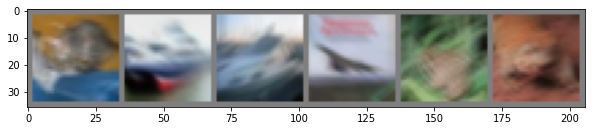

In [ ]:
# visualize data corrupted with motion blur
test_loader_impulse_noise_0 = DataLoader(test_data_corrupt_0, batch_size=6, num_workers=4, shuffle=False)

# get some random training images
dataiter = iter(test_loader_impulse_noise_0)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

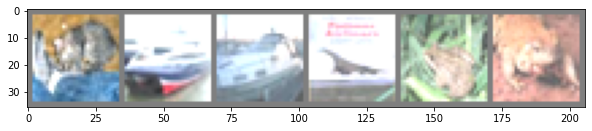

In [ ]:
# visualize data corrupted with frost
test_loader_impulse_noise_1 = DataLoader(test_data_corrupt_1, batch_size=6, num_workers=4, shuffle=False)

# get some random training images
dataiter = iter(test_loader_impulse_noise_1)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

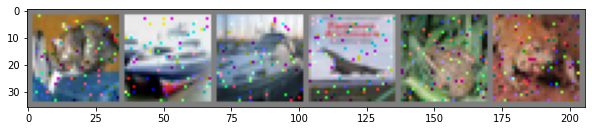

In [ ]:
# visualize data corrupted with impulse noise
test_loader_impulse_noise_2 = DataLoader(test_data_corrupt_2, batch_size=6, num_workers=4, shuffle=False)

# get some random training images
dataiter = iter(test_loader_impulse_noise_2)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

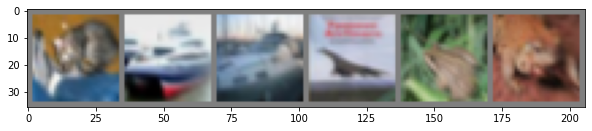

In [ ]:
# visualize data corrupted with zoom blur
test_loader_impulse_noise_3 = DataLoader(test_data_corrupt_3, batch_size=6, num_workers=4, shuffle=False)

# get some random training images
dataiter = iter(test_loader_impulse_noise_3)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

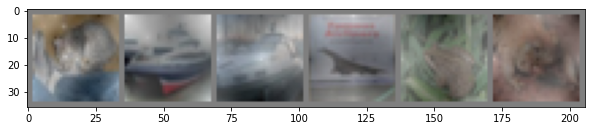

In [ ]:
# visualize data corrupted with fog
test_loader_impulse_noise_4 = DataLoader(test_data_corrupt_4, batch_size=6, num_workers=4, shuffle=False)

# get some random training images
dataiter = iter(test_loader_impulse_noise_4)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# create corrupted test loader with the correct batch_sizes
test_dataset = datasets.CIFAR10(root="./data_baseline_corrupt", train=False, download=True)




transform=transform_test_base


test_loader_impulse_noise_0 = DataLoader(test_data_corrupt_0, batch_size=TEST_BATCH_SIZE, num_workers=4, shuffle=False)
test_loader_impulse_noise_1 = DataLoader(test_data_corrupt_1, batch_size=TEST_BATCH_SIZE, num_workers=4, shuffle=False)
test_loader_impulse_noise_2 = DataLoader(test_data_corrupt_2, batch_size=TEST_BATCH_SIZE, num_workers=4, shuffle=False)
test_loader_impulse_noise_3 = DataLoader(test_data_corrupt_3, batch_size=TEST_BATCH_SIZE, num_workers=4, shuffle=False)
test_loader_impulse_noise_4 = DataLoader(test_data_corrupt_4, batch_size=TEST_BATCH_SIZE, num_workers=4, shuffle=False)

Abstract a function to test baseline model on corrupted test data.

In [ ]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.type(torch.LongTensor).to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

In [ ]:
# Define Baseline ResNet20 Model
resnet_base = ResNet_20(ResBlock, [3, 3, 3]).to(device)
resnet_base.load_state_dict(torch.load("model_baseline.pt"))

<All keys matched successfully>

- Motion Blur : 0.0976

In [ ]:
test_acc, test_loss = test_model(resnet_base, test_loader_impulse_noise_0, device)
print(f"The Test Accuracy of Motion Blur Corruption:{test_acc}")

The Test Accuracy of Motion Blur Corruption:0.0961


- Frost : 0.0234

In [ ]:
test_acc, test_loss = test_model(resnet_base, test_loader_impulse_noise_1, device)
print(f"The Test Accuracy of Frost Corruption:{test_acc}")

The Test Accuracy of Frost Corruption:0.0239


- Impulse Noise : 0.046

In [ ]:
test_acc, test_loss = test_model(resnet_base, test_loader_impulse_noise_2, device)
print(f"The Test Accuracy of Impulse Noise Corruption:{test_acc}")

The Test Accuracy of Impulse Noise Corruption:0.0449


- Zoom Blur : 0.0734



In [ ]:
test_acc, test_loss = test_model(resnet_base, test_loader_impulse_noise_3, device)
print(f"The Test Accuracy of Zoom Blur Corruption:{test_acc}")

The Test Accuracy of Zoom Blur Corruption:0.0734


- Fog : 0.0967

In [ ]:
test_acc, test_loss = test_model(resnet_base, test_loader_impulse_noise_4, device)
print(f"The Test Accuracy of Fog Corruption:{test_acc}")

The Test Accuracy of Fog Corruption:0.0983


### ii. Cutout

In [ ]:
# Load Cutout Model
resnet_cutout = ResNet_20(ResBlock, [3, 3, 3]).to(device)
resnet_cutout.load_state_dict(torch.load("model_cutout_2.pt"))

<All keys matched successfully>

- Motion Blur : 0.266

In [ ]:
test_acc, test_loss = test_model(resnet_cutout, test_loader_impulse_noise_0, device)
print(f"The Test Accuracy of Motion Blur Corruption: {test_acc}")

The Test Accuracy of Motion Blur Corruption: 0.2663


- Frost : 0.742

In [ ]:
test_acc, test_loss = test_model(resnet_cutout, test_loader_impulse_noise_1, device)
print(f"The Test Accuracy of Frost Corruption: {test_acc}")

The Test Accuracy of Frost Corruption: 0.7422


- Impulse Noise : 0.5455

In [ ]:
test_acc, test_loss = test_model(resnet_cutout, test_loader_impulse_noise_2, device)
print(f"The Test Accuracy of Impulse Noise Corruption:{test_acc}")

The Test Accuracy of Impulse Noise Corruption:0.5455


- Zoom Blur : 0.4454

In [ ]:
test_acc, test_loss = test_model(resnet_cutout, test_loader_impulse_noise_3, device)
print(f"The Test Accuracy of Zoom Blur Corruption:{test_acc}")

The Test Accuracy of Zoom Blur Corruption:0.4454


- Fog : 0.4085

In [ ]:
test_acc, test_loss = test_model(resnet_cutout, test_loader_impulse_noise_4, device)
print(f"The Test Accuracy of Fog Corruption:{test_acc}")

The Test Accuracy of Fog Corruption:0.4085


### iii. Mixup

In [ ]:
# Load Mixup Model
resnet_mixup = ResNet_20(ResBlock, [3, 3, 3]).to(device)
resnet_mixup.load_state_dict(torch.load("model_mixup_final.pt"))

<All keys matched successfully>

In [ ]:
testset = datasets.CIFAR10(root='~/data_corrupt_mixup', train=False, download=True)

testset_corrupt_mb = Corrupt_Data(testset, corrupt_name='motion_blur')
testset_corrupt_fr = Corrupt_Data(testset, corrupt_name='frost')
testset_corrupt_in = Corrupt_Data(testset, corrupt_name ='impulse_noise')
testset_corrupt_zb = Corrupt_Data(testset, corrupt_name='zoom_blur')
testset_corrupt_fo = Corrupt_Data(testset, corrupt_name='fog')

testloader_mb = torch.utils.data.DataLoader(testset_corrupt_mb, batch_size=100, shuffle=False, num_workers=4)
testloader_fr = torch.utils.data.DataLoader(testset_corrupt_fr, batch_size=100, shuffle=False, num_workers=4)
testloader_in = torch.utils.data.DataLoader(testset_corrupt_in, batch_size=100, shuffle=False, num_workers=4)
testloader_zb = torch.utils.data.DataLoader(testset_corrupt_zb, batch_size=100, shuffle=False, num_workers=4)
testloader_fo = torch.utils.data.DataLoader(testset_corrupt_fo, batch_size=100, shuffle=False, num_workers=4)


Files already downloaded and verified


In [ ]:
test_acc, test_loss = test_model(resnet_mixup, testloader_mb, device)
print(f"The Test Accuracy of Motion Blur Corruption (Mixup): {test_acc}")

The Test Accuracy of Motion Blur Corruption (Mixup): 0.306


In [ ]:
test_acc, test_loss = test_model(resnet_mixup, testloader_fr, device)
print(f"The Test Accuracy of Frost Corruption (Mixup): {test_acc}")

The Test Accuracy of Frost Corruption (Mixup): 0.8102


In [ ]:
test_acc, test_loss = test_model(resnet_mixup, testloader_in, device)
print(f"The Test Accuracy of Impulse Noise (Mixup): {test_acc}")

The Test Accuracy of Impulse Noise (Mixup): 0.5363


In [ ]:
test_acc, test_loss = test_model(resnet_mixup, testloader_zb, device)
print(f"The Test Accuracy of Zoom Blur (Mixup): {test_acc}")

The Test Accuracy of Zoom Blur (Mixup): 0.5751


In [ ]:
test_acc, test_loss = test_model(resnet_mixup, testloader_fo, device)
print(f"The Test Accuracy of Fog (Mixup): {test_acc}")

The Test Accuracy of Fog (Mixup): 0.5277


### iii. Auxillary Head

In [ ]:
from rot_dataset_corrupt import RotDataset_Corrupt

# construct test_loaders for auxillary head model
# construct corrupted test data set
args = arg_parser()

id_testdata_0 = RotDataset_Corrupt(test_dataset, train_mode=False, corrupt_name='motion_blur')
id_testdata_1 = RotDataset_Corrupt(test_dataset, train_mode=False, corrupt_name='frost')
id_testdata_2 = RotDataset_Corrupt(test_dataset, train_mode=False, corrupt_name='impulse_noise')
id_testdata_3 = RotDataset_Corrupt(test_dataset, train_mode=False, corrupt_name='zoom_blur')
id_testdata_4 = RotDataset_Corrupt(test_dataset, train_mode=False, corrupt_name='fog')

# construct corrupted dataloaders for auxillary head
test_loader_impulse_noise_0 = DataLoader(id_testdata_0, batch_size=args.batch_size, num_workers=4, shuffle=False)
test_loader_impulse_noise_1 = DataLoader(id_testdata_1, batch_size=args.batch_size, num_workers=4, shuffle=False)
test_loader_impulse_noise_2 = DataLoader(id_testdata_2, batch_size=args.batch_size, num_workers=4, shuffle=False)
test_loader_impulse_noise_3 = DataLoader(id_testdata_3, batch_size=args.batch_size, num_workers=4, shuffle=False)
test_loader_impulse_noise_4 = DataLoader(id_testdata_4, batch_size=args.batch_size, num_workers=4, shuffle=False)

In [ ]:
# Define Baseline ResNet20 Model
args = arg_parser()
num_classes = 10
resnet_auxhead = WideResNet(args.layers, num_classes, args.widen_factor, dropRate=args.droprate)
resnet_auxhead.rot_head = nn.Linear(64, 4)
resnet_auxhead.to(device)
resnet_auxhead.load_state_dict(torch.load("trained_model_rot.pth"))

<All keys matched successfully>

- Motion Blur : 0.61

In [ ]:
test_loss, test_acc = test(args, resnet_auxhead, test_loader_impulse_noise_0)
print(f"The Test Accuracy of Motion Blur Corruption:{test_acc}")

100%|██████████| 79/79 [00:10<00:00,  7.35it/s]

The Test Accuracy of Motion Blur Corruption:0.6068


- Frost : 0.63

In [ ]:
test_loss, test_acc = test(args, resnet_auxhead, test_loader_impulse_noise_1)
print(f"The Test Accuracy of Frost Corruption:{test_acc}")

100%|██████████| 79/79 [00:44<00:00,  1.78it/s]

The Test Accuracy of Frost Corruption:0.6312


- Impulse Noise : 0.47

In [ ]:
test_loss, test_acc = test(args, resnet_auxhead, test_loader_impulse_noise_2)
print(f"The Test Accuracy of Impulse Noise Corruption:{test_acc}")

100%|██████████| 79/79 [00:06<00:00, 12.50it/s]

The Test Accuracy of Impulse Noise Corruption:0.4672


- Zoom Blur : 0.76

In [ ]:
test_loss, test_acc = test(args, resnet_auxhead, test_loader_impulse_noise_3)
print(f"The Test Accuracy of Zoom Blur Corruption:{test_acc}")

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

The Test Accuracy of Zoom Blur Corruption:0.7612


- Fog : 0.61

In [ ]:
test_loss, test_acc = test(args, resnet_auxhead, test_loader_impulse_noise_4)
print(f"The Test Accuracy of Fog Corruption:{test_acc}")

100%|██████████| 79/79 [00:08<00:00,  9.11it/s]

The Test Accuracy of Fog Corruption:0.613


### 6. Test Robustness of Best Regularized Models to White-Box FGSM adversarial examples with various epsilon values

In [ ]:
import attacks

i. Cutout

In [ ]:
test_set = CIFAR10(root="/data", mode="val", download=True, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=4)

def robust_cutout(eps, iter, alpha, attack):
  whitebox = ResNet_20(ResBlock, [3, 3, 3])
  whitebox.load_state_dict(torch.load("model_cutout_2.pt"))

  whitebox = whitebox.to(device)
  whitebox.eval(); 

  #test_model(whitebox, test_loader, device)
  #print("Initial Accuracy of Whitebox Model: ",test_acc)

  ## Test the model against an adversarial attack

  # TODO: Set attack parameters here
  ATK_EPS = eps
  ATK_ITERS = iter
  ATK_ALPHA = alpha

  whitebox_correct = 0.
  running_total = 0.

  for batch_idx,(data,labels) in enumerate(test_loader):
      data = data.to(device) 
      labels = labels.type(torch.LongTensor).to(device)

      # TODO: Perform adversarial attack here
      adv_data = attacks.FGSM_attack(model=whitebox, device=device, dat=data, lbl=labels, eps=ATK_EPS)
      
      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      assert(adv_data.max() == 1.)
      assert(adv_data.min() == 0.)
      
      # Compute accuracy on perturbed data
      with torch.no_grad():
          whitebox_outputs = whitebox(adv_data)
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()
          running_total += labels.size(0)

  # print final 
  whitebox_acc = whitebox_correct/running_total
  print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

  print("Done!")

  return whitebox_acc

Using downloaded and verified file: /data/cifar10_trainval_F22.zip
Extracting /data/cifar10_trainval_F22.zip to /data
Files already downloaded and verified


In [ ]:
epsilon_array = np.arange(0.0,0.14,0.02)
iter = 10
fgsm_acc_array = []


for e in epsilon_array:
  print("Epsilon ", e)
  fgsm_acc = robust_cutout(e, iter, 1.85*(e/iter), "FGSM")
  fgsm_acc_array.append(fgsm_acc)
  print(50*"--")

Epsilon  0.0
Attack Epsilon: 0.0; Whitebox Accuracy: 0.0608
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.02
Attack Epsilon: 0.02; Whitebox Accuracy: 0.0168
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.04
Attack Epsilon: 0.04; Whitebox Accuracy: 0.0082
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.06
Attack Epsilon: 0.06; Whitebox Accuracy: 0.0068
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.08
Attack Epsilon: 0.08; Whitebox Accuracy: 0.0054
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.1
Attack Epsilon: 0.1; Whitebox Accuracy: 0.0042
Done!
-------------------------------------------------------------------------------------------

ii. Mixup

In [ ]:
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
testset = datasets.CIFAR10(root='~/data_mixup', train=False, download=False, transform=transform_test)
testloader_mixup = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

In [ ]:
def robust_mixup(eps, iter, alpha, attack):
  whitebox = ResNet_20(ResBlock, [3, 3, 3])
  whitebox.load_state_dict(torch.load("model_mixup_final.pt"))

  whitebox = whitebox.to(device)
  whitebox.eval(); 

  #test_model(whitebox, test_loader, device)
  #print("Initial Accuracy of Whitebox Model: ",test_acc)

  ## Test the model against an adversarial attack

  # TODO: Set attack parameters here
  ATK_EPS = eps
  ATK_ITERS = iter
  ATK_ALPHA = alpha

  whitebox_correct = 0.
  running_total = 0.

  for batch_idx,(data,labels) in enumerate(testloader_mixup):
      data = data.to(device) 
      labels = labels.type(torch.LongTensor).to(device)

      # TODO: Perform adversarial attack here
      adv_data = attacks.FGSM_attack(model=whitebox, device=device, dat=data, lbl=labels, eps=ATK_EPS)
      
      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      assert(adv_data.max() == 1.)
      assert(adv_data.min() == 0.)
      
      # Compute accuracy on perturbed data
      with torch.no_grad():
          whitebox_outputs = whitebox(adv_data)
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()
          running_total += labels.size(0)

  # print final 
  whitebox_acc = whitebox_correct/running_total
  print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

  print("Done!")

  return whitebox_acc

In [ ]:
epsilon_array = np.arange(0.0,0.14,0.02)
iter = 10
fgsm_acc_array = []


for e in epsilon_array:
  print("Epsilon ", e)
  fgsm_acc = robust_mixup(e, iter, 1.85*(e/iter), "FGSM")
  fgsm_acc_array.append(fgsm_acc)
  print(50*"--")

Epsilon  0.0
Attack Epsilon: 0.0; Whitebox Accuracy: 0.3746
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.02
Attack Epsilon: 0.02; Whitebox Accuracy: 0.1675
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.04
Attack Epsilon: 0.04; Whitebox Accuracy: 0.1215
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.06
Attack Epsilon: 0.06; Whitebox Accuracy: 0.1043
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.08
Attack Epsilon: 0.08; Whitebox Accuracy: 0.0945
Done!
----------------------------------------------------------------------------------------------------
Epsilon  0.1
Attack Epsilon: 0.1; Whitebox Accuracy: 0.0874
Done!
-------------------------------------------------------------------------------------------

iii. Auxilliary Head

In [ ]:
# dataset 
id_testdata = datasets.CIFAR10('./data_aux_head/', train=False, download=True)
id_testdata = RotDataset(id_testdata, train_mode=False)
test_loader = DataLoader(id_testdata, batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True)

def robust_auxhead(eps, iter, alpha, attack):
  args = arg_parser()
  num_classes = 10
  whitebox = WideResNet(args.layers, num_classes, args.widen_factor, dropRate=args.droprate)
  whitebox.rot_head = nn.Linear(64, 4)
  whitebox.to(device)
  whitebox.load_state_dict(torch.load("trained_model_rot.pth"))
  whitebox = whitebox.to(device)
  whitebox.eval(); 

  ## Test the model against an adversarial attack

  # TODO: Set attack parameters here
  ATK_EPS = eps
  ATK_ITERS = iter
  ATK_ALPHA = alpha

  whitebox_correct = 0.
  running_total = 0.

  loss = 0.
  acc = 0.

  for x_tf_0, x_tf_90, x_tf_180, x_tf_270, batch_y in tqdm(test_loader):  
      batch_size = x_tf_0.shape[0]

      batch_x = torch.cat([x_tf_0, x_tf_90, x_tf_180, x_tf_270], 0).cuda()
      batch_y = batch_y.cuda()
      
      # TODO: Perform adversarial attack here
      adv_data = attacks.FGSM_attack(model=whitebox, device=device, dat=batch_x, lbl=labels, eps=ATK_EPS)
      
      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-batch_x)) <= (ATK_EPS + 1e-5) )
      assert(adv_data.max() == 1.)
      assert(adv_data.min() == 0.)

      batch_rot_y = torch.cat((
          torch.zeros(batch_size),
          torch.ones(batch_size),
          2 * torch.ones(batch_size),
          3 * torch.ones(batch_size)
      ), 0).long().cuda()
      
      logits, pen = whitebox(adv_data)
      
      classification_logits = logits[:batch_size]
      rot_logits = whitebox.rot_head(pen)

      print("John")

      classification_loss = F.cross_entropy(classification_logits, batch_y)
      rot_loss = F.cross_entropy(rot_logits, batch_rot_y)  
      
      # use self-supervised rotation loss 
      if args.method == 'rot':
          loss += classification_loss + args.rot_loss_weight * rot_loss 
      # baseline, maximum softmax probability
      elif args.method == 'msp':
          loss += classification_loss

      # accuracy
      with torch.no_grad():
        pred = classification_logits.data.max(1)[1]
        acc += pred.eq(batch_y.data).sum().item()

      whitebox_acc = acc / len(test_loader.dataset)

  # print final 
  whitebox_acc = whitebox_correct/running_total
  print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

  print("Done!")

  return whitebox_acc


Files already downloaded and verified


In [ ]:
epsilon_array = np.arange(0.0,0.14,0.02)
iter = 10
fgsm_acc_array = []


for e in epsilon_array:
  print("Epsilon ", e)
  fgsm_acc = robust_auxhead(e, iter, 1.85*(e/iter), "FGSM")
  fgsm_acc_array.append(fgsm_acc)
  print(50*"--")

Epsilon  0.0


  0%|          | 0/79 [00:00<?, ?it/s]


TypeError: ignored